In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import torch
import falkon
import os, sys
import time
import matplotlib.pyplot as plt
import math
from libsvmdata import fetch_libsvm
import libsvmdata

[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


/home/giacomo/Dropbox/unige/falkon/falkon/falkon/utils/switches.py:21: UserWarning: Failed to initialize CUDA library; falling back to CPU. Set 'use_cpu' to True to avoid this warning.
  warnings.warn(get_error_str("CUDA", None))


In [3]:
sys.path.append("../benchmark")

In [950]:
libsvmdata.supported

['a1a',
 'a1a_test',
 'a2a',
 'a2a_test',
 'a3a',
 'a3a_test',
 'a4a',
 'a4a_test',
 'a5a',
 'a5a_test',
 'a6a',
 'a6a_test',
 'a7a',
 'a7a_test',
 'a8a',
 'a8a_test',
 'a9a',
 'a9a_test',
 'abalone',
 'abalone_scale',
 'aloi',
 'australian',
 'australian_scale',
 'bibtex',
 'bodyfat',
 'breast-cancer',
 'breast-cancer_scale',
 'cadata',
 'cifar10',
 'cifar10_test',
 'cod-rna',
 'cod-rna_test',
 'colon-cancer',
 'connect-4',
 'covtype.binary',
 'covtype.multiclass',
 'covtype.multiclass_scale',
 'cpusmall',
 'delicious',
 'diabetes',
 'diabetes_scale',
 'dna',
 'duke breast-cancer',
 'epsilon',
 'epsilon_test',
 'eunite2001',
 'finance',
 'finance-tf-idf',
 'fourclass',
 'fourclass_scale',
 'german.numer',
 'german.numer_scale',
 'gisette',
 'glass',
 'heart',
 'heart_scale',
 'HIGGS',
 'housing',
 'ijcnn1',
 'ijcnn1_test',
 'ionosphere',
 'iris',
 'kdda_train',
 'letter',
 'leukemia',
 'leukemia_test',
 'liver-disorders',
 'liver-disorders_scale',
 'liver-disorders_test',
 'madelon',


In [4]:
from falkon.hypergrad.complexity_reg import GPComplexityReg, SimpleFalkonComplexityReg
from falkon.hypergrad.common import test_train_predict
from summary import get_writer
writer = get_writer("test")

## What to do here

 - Download SVMLight datasets
 - Run the SGPR with RBF kernel optimizing centers
 - Compare with the PCA centers
 
 
We use LessIsMore notation to express the different projected kernel-ridge problems.


We have that $Z_m$ is the projected feature-map. In the case of Nystrom uniform sampling it is the kernel feature-map $\phi$ applied to the chosen samples $\tilde{x}_i, \dots, \tilde{x}_m$.

The solution to the learning problem is
$$
\tilde{f}_m(x) = \sum_{i=1}^m \tilde{\alpha}_i z_i(x)
$$
where the coefficient vector is
$$
\tilde{\alpha} = (Z_m Z_n^\top Z_n Z_m^\top + \lambda n Z_m Z_m^\top)^\dagger Z_m Z_n^\top Y
$$

Let $K = Z_n Z_n^\top$ be the kernel matrix with eigendecomposition $K = \sum_{i=1}^n \sigma_i u_i u_i^\top$. By choosing $Z_m = U_m^\top Z_n$ we 

In [5]:
def compare_ker_fro(model, X):
    centers = model.centers.detach()
    M = centers.shape[0]
    kernel = falkon.kernels.GaussianKernel(model.sigma.detach(), falkon_opt)
    
    # Nystrom B, G
    Bnm_nys = kernel(X, centers)
    Gmm_nys = kernel(centers, centers)
    # SVD B, G
    full_kernel = kernel(X, X)
    u, s, v = torch.svd(full_kernel)
    Bnm_svd = full_kernel @ u[:, :M]
    Gmm_svd = u[:,:M].T @ full_kernel @ u[:, :M]
    
    Ktilde_nys = Bnm_nys @ torch.pinverse(Gmm_nys) @ Bnm_nys.T
    Ktilde_svd = Bnm_svd @ torch.pinverse(Gmm_svd) @ Bnm_svd.T
    Ktilde_svd_2 = u[:, :M] @ torch.diag(s[:M]) @ u[:, :M].T
    torch.testing.assert_allclose(Ktilde_svd, Ktilde_svd_2)
    
    return torch.sum((Ktilde_nys - Ktilde_svd)**2)
def compare_ker_tr(model, X):
    centers = model.centers.detach()
    M = centers.shape[0]
    kernel = falkon.kernels.GaussianKernel(model.sigma.detach(), falkon_opt)
    
    # Nystrom B, G
    Bnm_nys = kernel(X, centers)
    Gmm_nys = kernel(centers, centers)
    # SVD B, G
    full_kernel = kernel(X, X)
    u, s, v = torch.svd(full_kernel)
    Bnm_svd = full_kernel @ u[:, :M]
    Gmm_svd = u[:,:M].T @ full_kernel @ u[:, :M]
    
    Ktilde_nys = Bnm_nys @ torch.pinverse(Gmm_nys) @ Bnm_nys.T
    Ktilde_svd = Bnm_svd @ torch.pinverse(Gmm_svd) @ Bnm_svd.T
    Ktilde_svd_2 = u[:, :M] @ torch.diag(s[:M]) @ u[:, :M].T
    torch.testing.assert_allclose(Ktilde_svd, Ktilde_svd_2)
    
    return torch.trace(Ktilde_nys - Ktilde_svd)

In [6]:
def simple_solve_nkrr(Bnm, Gmm, Y, la):
    h = Bnm.T @ Bnm + la * Bnm.shape[0] * Gmm
    alpha = torch.pinverse(h) @ Bnm.T @ Y
    return alpha
def simple_solve_krr(kernel, Xtr, Ytr, la):
    alpha = (torch.pinverse(kernel(Xtr, Xtr) + 
                           Xtr.shape[0] * la * torch.eye(Xtr.shape[0])) 
             @ Ytr)
    return alpha
def simple_pred_nkrr(Bnm, alpha):
    return Bnm @ alpha
def simple_pred_krr(kernel, Xtr, Xts, alpha):
    return kernel(Xts, Xtr) @ alpha

In [26]:
def mse(y_true, y_pred):
    return torch.mean((y_true.reshape(-1) - y_pred.reshape(-1))**2), "mse"
def preprocess_dataset(X, Y, n_train):
    shuffle = np.random.permutation(X.shape[0])
    X = X[shuffle]
    Y = Y[shuffle]
    Xtr = X[:n_train].clone().to(dtype=torch.float64)
    Ytr = Y[:n_train].clone().to(dtype=torch.float64)
    Xts = X[n_train:].clone().to(dtype=torch.float64)
    Yts = Y[n_train:].clone().to(dtype=torch.float64)
    mean = Xtr.mean(axis=0, keepdims=True)
    std = Xtr.std(axis=0, keepdims=True)
    Xtr -= mean
    Xts -= mean
    Xtr /= std
    Xts /= std
    return Xtr, Ytr, Xts, Yts

In [8]:
def get_random_bg(Xtr, M, Xts=None):
    centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
    Bnm = kernel(Xtr, centers_init)
    Gmm = kernel(centers_init, centers_init)
    Bnm_test = None
    if Xts is not None:
        Bnm_test = kernel(Xts, centers_init)
    return Bnm, Gmm, Bnm_test
def get_nystrom_bg(Xtr, M, Xts=None):
    centers_init = Xtr[np.random.choice(Xtr.shape[0], size=M, replace=False), :]
    Bnm = kernel(Xtr, centers_init)
    Gmm = kernel(centers_init, centers_init)
    Bnm_test = None
    if Xts is not None:
        Bnm_test = kernel(Xts, centers_init)
    return Bnm, Gmm, Bnm_test
def get_svd_bg(Xtr, M, Xts=None):
    full_kernel = kernel(Xtr, Xtr)
    u, s, v = torch.svd(full_kernel)
    Bnm = full_kernel @ u[:, :M]
    Gmm = u[:,:M].T @ full_kernel @ u[:, :M]
    Bnm_test = None
    if Xts is not None:
        Bnm_test = kernel(Xts, Xtr) @ u[:, :M]
    return Bnm, Gmm, Bnm_test
def get_train_error(Bnm, Bnm_test, Gmm, Ytr, Yts, penalty):
    alpha = simple_solve_nkrr(Bnm, Gmm, Ytr, penalty)
    train_preds = simple_pred_nkrr(Bnm, alpha)
    err, name = mse(Ytr, train_preds)
    return err
def get_test_error(Bnm, Bnm_test, Gmm, Ytr, Yts, penalty):
    alpha = simple_solve_nkrr(Bnm, Gmm, Ytr, penalty)
    test_preds = simple_pred_nkrr(Bnm_test, alpha)
    err, name = mse(Yts, test_preds)
    return err
def krr_train_error(Xtr, Xts, Ytr, Yts, kernel, la):
    alpha = simple_solve_krr(kernel, Xtr, Ytr, la)
    train_preds = simple_pred_krr(kernel, Xtr, Xtr, alpha)
    err, name = mse(Ytr, train_preds)
    return err
def krr_test_error(Xtr, Xts, Ytr, Yts, kernel, la):
    alpha = simple_solve_krr(kernel, Xtr, Ytr, la)
    test_preds = simple_pred_krr(kernel, Xtr, Xts, alpha)
    err, name = mse(Yts, test_preds)
    return err

In [9]:
dset_sigmas_15la = {
    "cpusmall": 8.,
    "abalone": 20.,
    "space_ga": 3.,
    "svmguide1": 3.,
    "cadata": 5.,
}

In [10]:
def load_dset(dset_name, n_train=1000, penalty=8., sigma=None):
    X, y = fetch_libsvm(dset_name)
    X = torch.from_numpy(np.asarray(X.todense())).float()
    Y = torch.from_numpy(y.reshape(-1, 1)).float()
    print(X.shape, Y.shape)
    Xtr, Ytr, Xts, Yts = preprocess_dataset(X, Y, n_train=n_train)

    penalty_init = torch.tensor(penalty, dtype=Xtr.dtype)
    if sigma is not None:
        sigma_init = torch.tensor([sigma], dtype=Xtr.dtype)
    else:
        sigma_init = torch.tensor([dset_sigmas_15la[dset_name]], dtype=Xtr.dtype)

    falkon_opt = falkon.FalkonOptions(keops_active="no", use_cpu=True)
    kernel = falkon.kernels.GaussianKernel(sigma_init, opt=falkon_opt)
    
    return Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel

### Short analysis of any given dataset to look for best sigma

In [21]:
dset_name = "space_ga"
X, y = fetch_libsvm(dset_name)
X = torch.from_numpy(np.asarray(X.todense())).float()
Y = torch.from_numpy(y.reshape(-1, 1)).float()
print(X.shape, Y.shape)
Xtr, Ytr, Xts, Yts = preprocess_dataset(X, Y, n_train=1000)

Dataset: space_ga
torch.Size([3107, 6]) torch.Size([3107, 1])


In [22]:
penalty_init = torch.tensor(8., dtype=Xtr.dtype)
sigma_init = torch.tensor([dset_sigmas_15la[dset_name]], dtype=Xtr.dtype)

falkon_opt = falkon.FalkonOptions(keops_active="no", use_cpu=True)
kernel = falkon.kernels.GaussianKernel(sigma_init, opt=falkon_opt)

In [1460]:
print(krr_train_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init)))
print(krr_test_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init)))

tensor(0.0140, dtype=torch.float64)
tensor(0.0136, dtype=torch.float64)


## Error vs. M plots.

We solve the learning problem in closed-form for different values of `M`. We compare the error obtained for different versions of the problem:

 1. Full kernel-ridge regression is the baseline, does not change with M.
 2. Nystrom KRR with uniformly chosen centers
 3. ~Nystrom KRR with random Gaussian centers
 4. ~Nystrom KRR with SVD centers

In [11]:
def error_evolution(m_list, num_reps, err_type, Xtr, Xts, Ytr, Yts, kernel, la):
    if err_type == "train":
        krr_err_fn = krr_train_error
        get_err_fn = get_train_error
    else:
        krr_err_fn = krr_test_error
        get_err_fn = get_test_error
    
    Kfull = kernel(Xtr, Xtr)
    err_krr = krr_err_fn(Xtr, Xts, Ytr, Yts, kernel, la)

    err_random, err_nystrom, err_svd = [], [], []
    err_random_std, err_nystrom_std = [], []
    fro_random, fro_nystrom, fro_svd = [], [], []
    for m in m_list:
        errs = []
        for i in range(num_reps):
            Bnm, Gmm, Bnm_test = get_random_bg(Xtr, m, Xts)
            errs.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))
        err_random.append(np.mean(errs))
        err_random_std.append(np.std(errs))

        errs = []
        for i in range(num_reps):
            Bnm, Gmm, Bnm_test = get_nystrom_bg(Xtr, m, Xts)
            errs.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))
        err_nystrom.append(np.mean(errs))
        err_nystrom_std.append(np.std(errs))

        Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, m, Xts)
        err_svd.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))

        # Frobenius error to full kernel
        Bnm, Gmm, Bnm_test = get_random_bg(Xtr, m, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_random.append(torch.sum((Kfull - Ktilde)**2))

        Bnm, Gmm, Bnm_test = get_nystrom_bg(Xtr, m, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_nystrom.append(torch.sum((Kfull - Ktilde)**2))

        Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, m, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_svd.append(torch.sum((Kfull - Ktilde)**2))
        print(m, end=".")
    return {
        "err_random": np.asarray(err_random),
        "err_nystrom": np.asarray(err_nystrom),
        "err_svd": np.asarray(err_svd),
        "err_random_std": np.asarray(err_random_std),
        "err_nystrom_std": np.asarray(err_nystrom_std),
        "fro_random": np.asarray(fro_random),
        "fro_nystrom": np.asarray(fro_nystrom),
        "fro_svd": np.asarray(fro_svd),
        "err_krr": err_krr
    }

In [12]:
def plot_error_evolution(m_list, data, err_type, figax=None, title=""):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    ax1 = ax.twinx()
    # ax.plot(m_list, err_data["err_random"], label="random", color="#381642")
    # ax.fill_between(m_list, 
    #                 err_data["err_random"] - err_data["err_random_std"], 
    #                 err_data["err_random"] + err_data["err_random_std"],
    #                 color="#7f528c", alpha=0.2)
    # ax1.plot(m_list, err_data["fro_random"], color="#381642", linestyle="--", label="random")

    ax.plot(m_list, data["err_nystrom"], label="nystrom", color="#1a3f93")
    ax.fill_between(m_list, 
                    data["err_nystrom"] - data["err_nystrom_std"], 
                    data["err_nystrom"] + data["err_nystrom_std"],
                    color="#738bc4", alpha=0.2)
    ax1.plot(m_list, data["fro_nystrom"], color="#1a3f93", linestyle="--", label="nystrom")

    ax.plot(m_list, data["err_svd"], label="SVD", color="#366d0e")
    ax1.plot(m_list, data["fro_svd"], color="#366d0e", linestyle="--", label="SVD")

    ax.plot(m_list, [data["err_krr"].item()] * len(m_list), color="red", label="Full KRR")

    ax1.set_yscale("log")

    ax.legend(loc="best")
    ax.grid()

    ax.set_xlabel("M")
    ax.set_ylabel("%s MSE" % (err_type))
    ax1.set_ylabel("Frobenius norm to full kernel")
    ax.set_title(title)
    return fig, ax

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


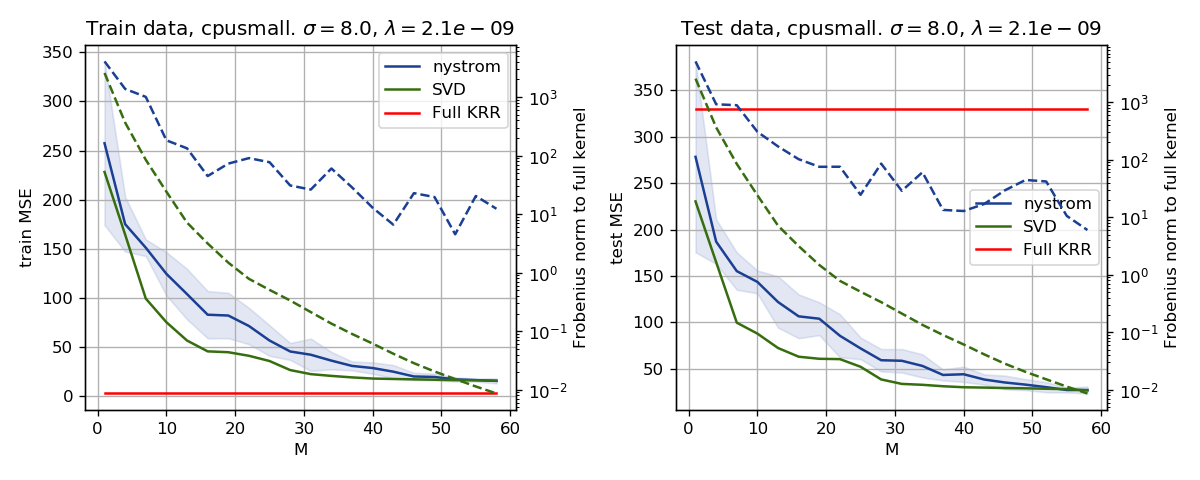

Dataset: abalone
torch.Size([4177, 8]) torch.Size([4177, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


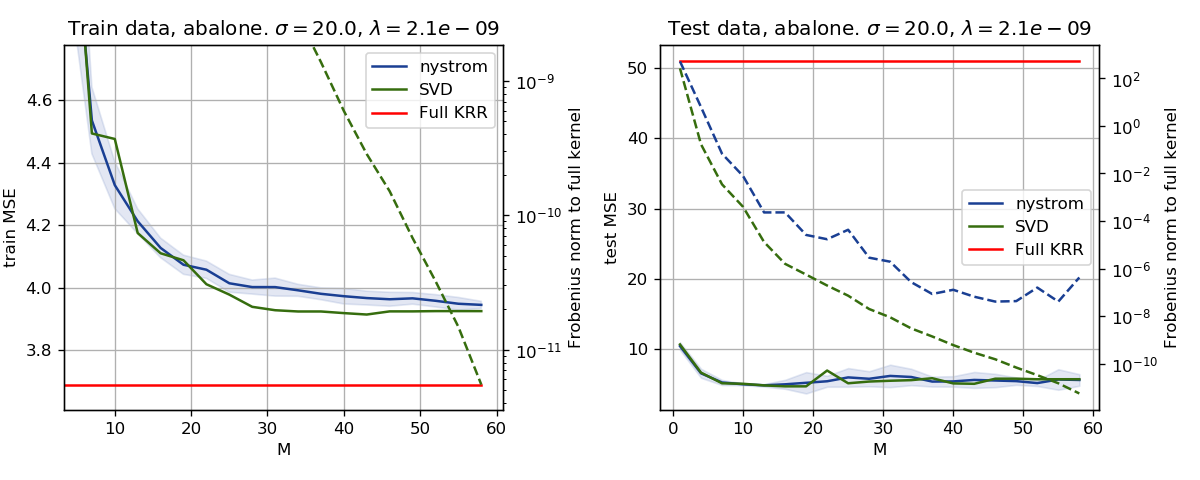

Dataset: space_ga
torch.Size([3107, 6]) torch.Size([3107, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


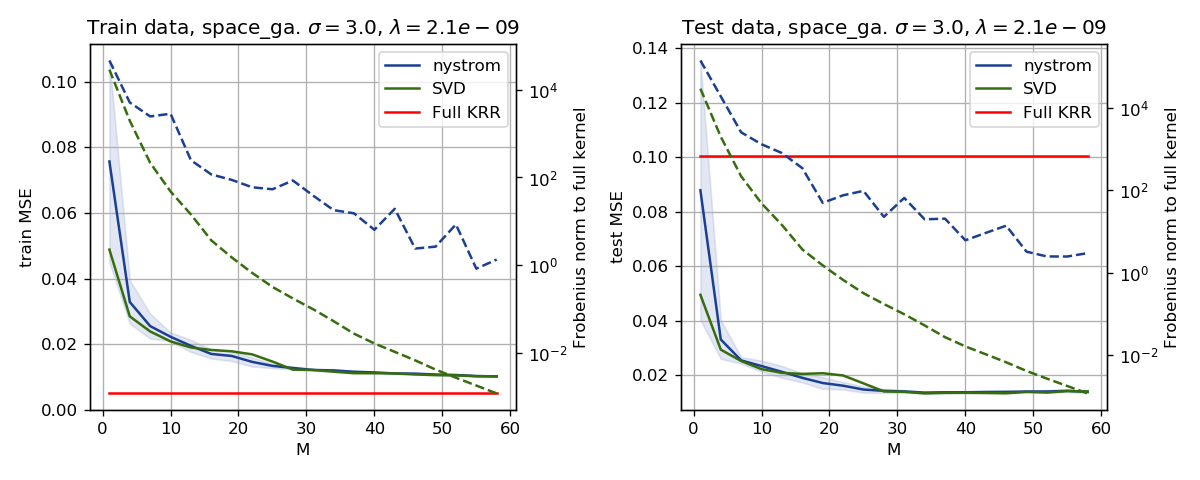

Dataset: svmguide1
torch.Size([3089, 4]) torch.Size([3089, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


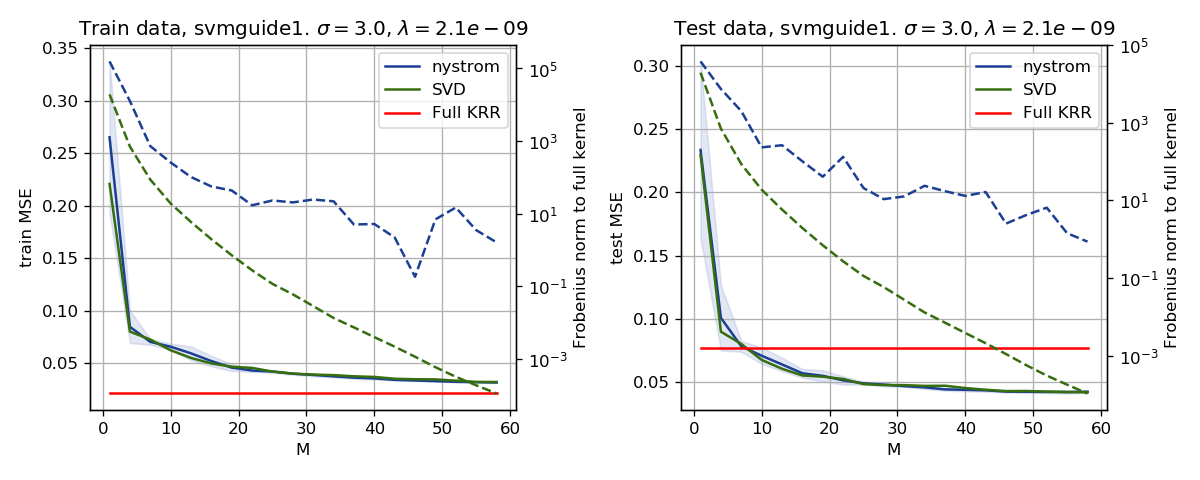

Dataset: cadata
torch.Size([20640, 8]) torch.Size([20640, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


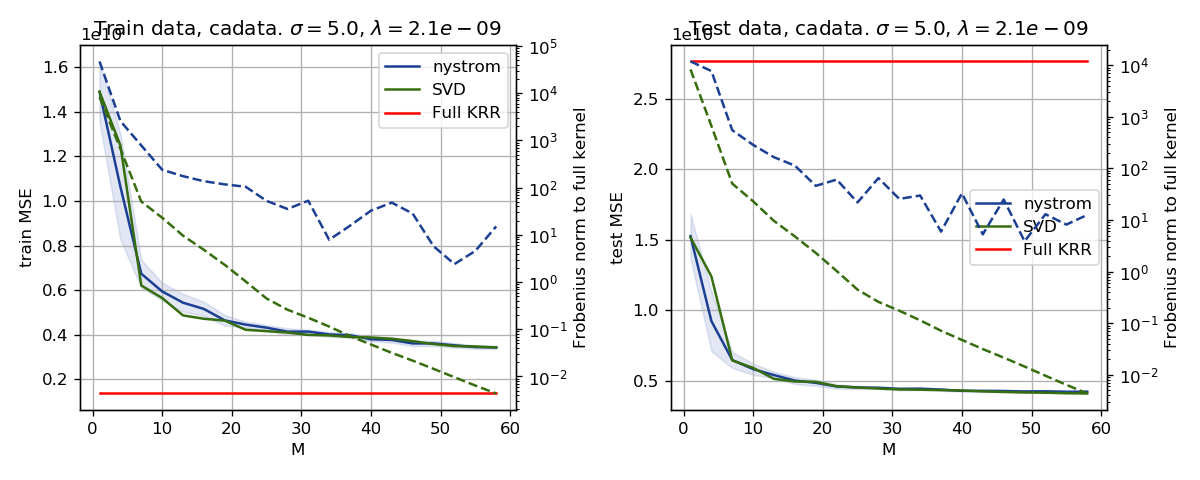

In [1680]:
for dset_name in dset_sigmas_15la.keys():
    Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=20)
    m_list = list(range(1, 60, 3))
    train_err_data = error_evolution(m_list, 15, "train", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    test_err_data = error_evolution(m_list, 15, "test", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
        dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
    plot_error_evolution(m_list, train_err_data, "train", (fig, ax[0]), title)
    title = "Test data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
        dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
    plot_error_evolution(m_list, test_err_data, "test", (fig, ax[1]), title)
    fig.tight_layout()
    fig.savefig("/home/giacomo/Dropbox/unige/hyperopt/figures/%s_err_with_m_280420_v4.png" % (dset_name), dpi=400)

In [1677]:
dset_name = "svmguide1"
Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=5)

Dataset: svmguide1
torch.Size([3089, 4]) torch.Size([3089, 1])


In [1678]:
train_err_data = error_evolution(m_list, 15, "train", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))

1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

<IPython.core.display.Javascript object>


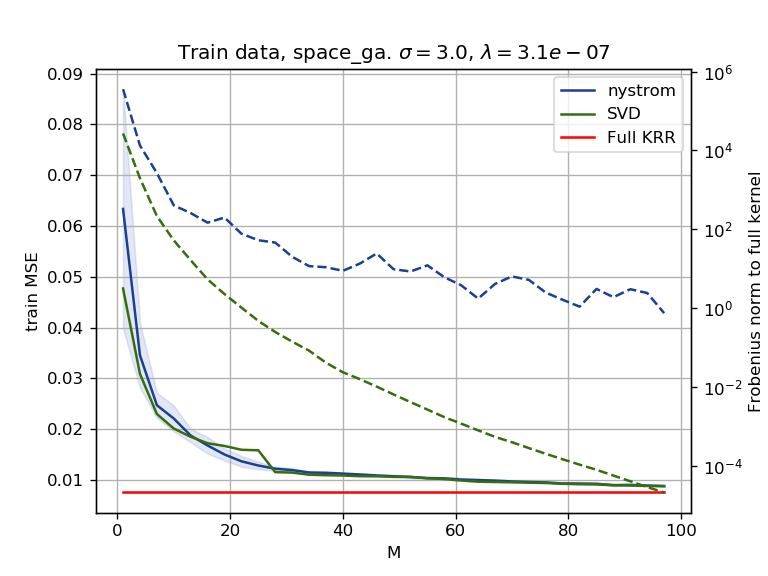

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef1a3290>)

In [1611]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


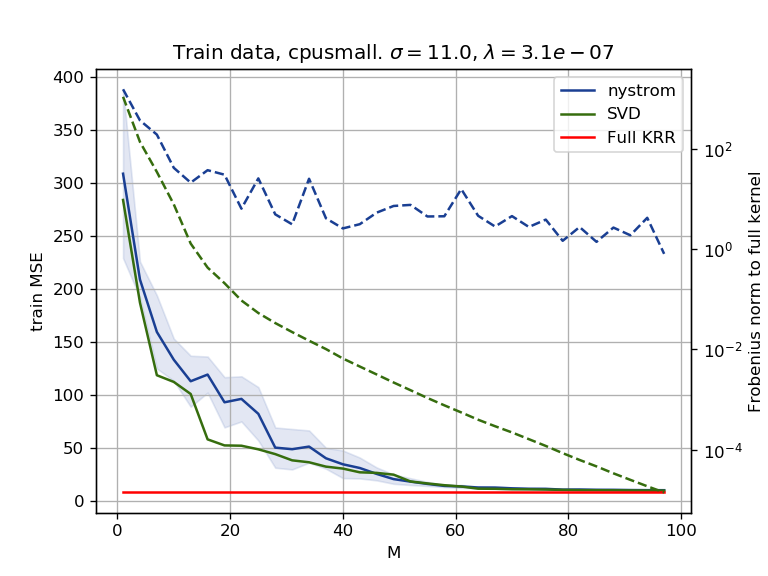

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef32f910>)

In [1608]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


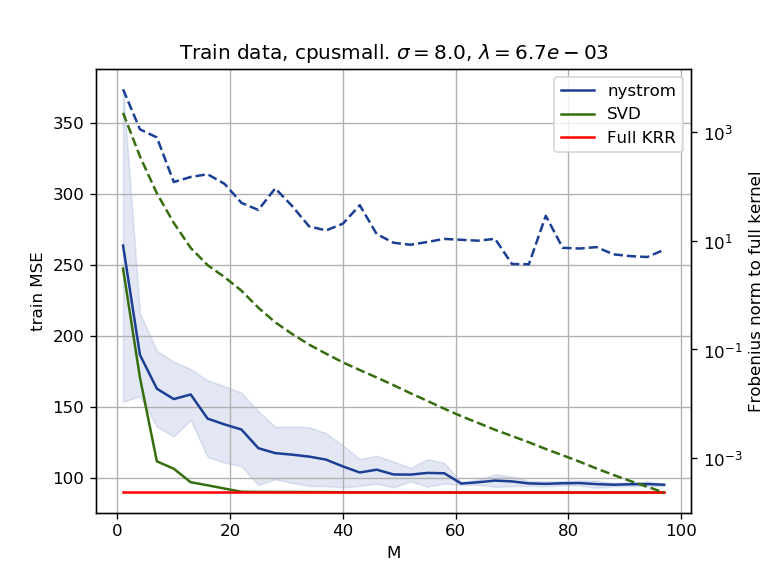

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef57c250>)

In [1603]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


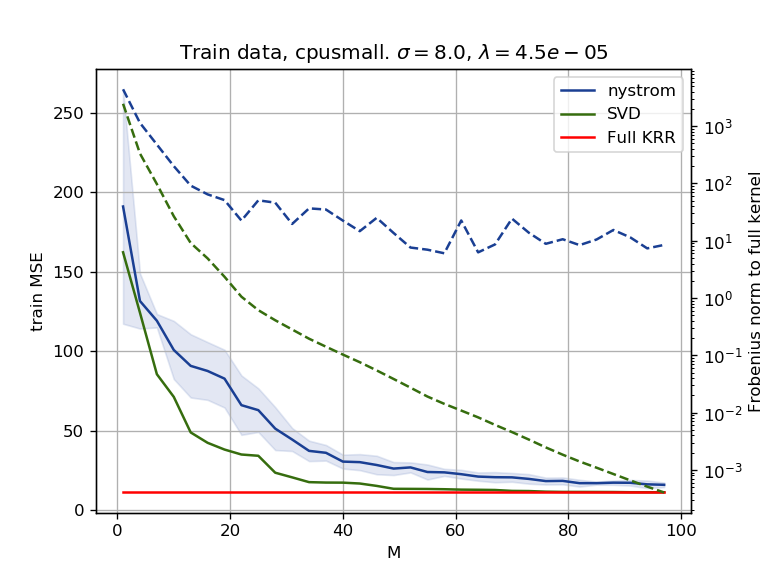

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef5b3790>)

In [1600]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


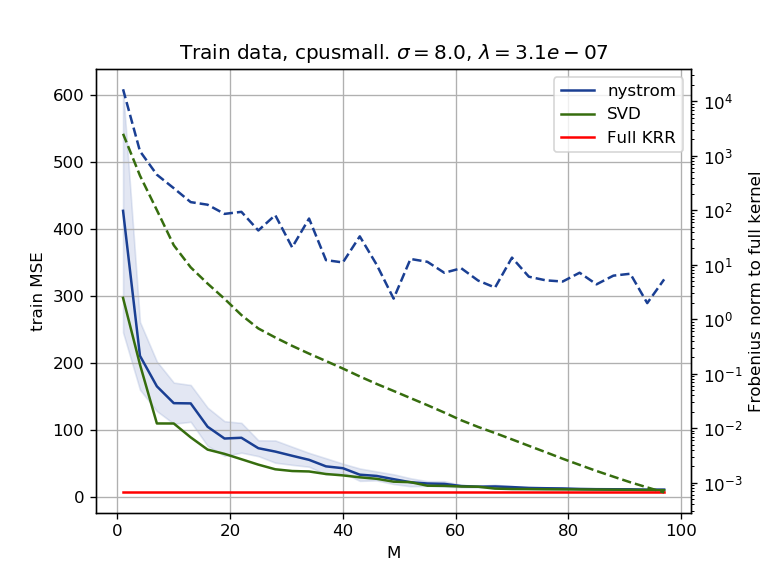

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef898750>)

In [1597]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

In [1469]:
test_err_data = error_evolution(m_list, 15, "test", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))

1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.61.64.67.70.73.76.79.82.85.88.91.94.97.

<IPython.core.display.Javascript object>


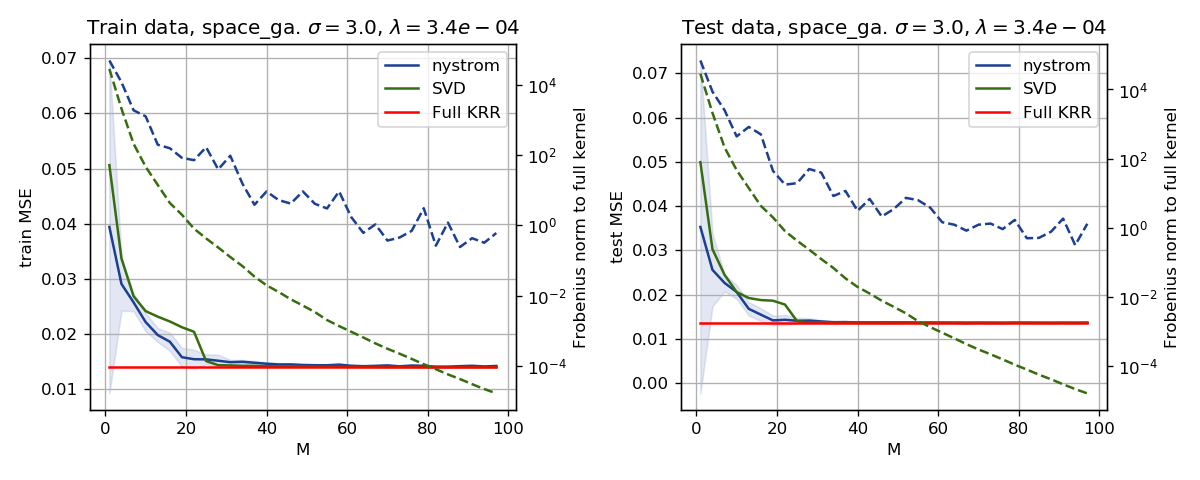

In [1476]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", (fig, ax[0]), title)
title = "Test data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, test_err_data, "test", (fig, ax[1]), title)
fig.tight_layout()
fig.savefig("%s_err_with_m.png" % (dset_name), dpi=600)

<IPython.core.display.Javascript object>


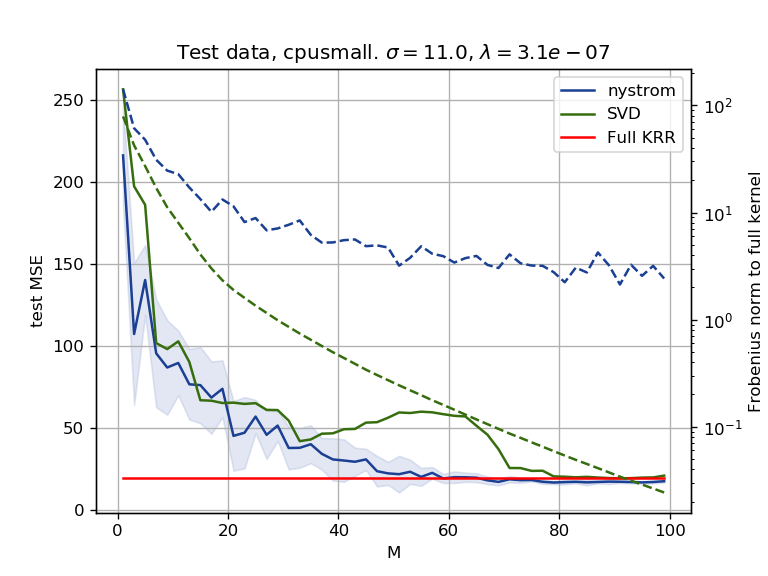

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0f522d350>)

<IPython.core.display.Javascript object>


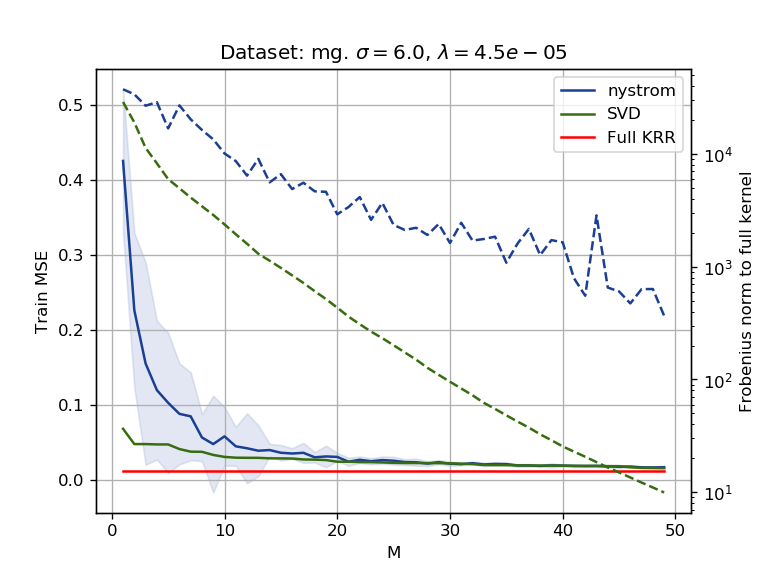

Text(0.5, 1.0, 'Dataset: mg. $\\sigma=6.0$, $\\lambda=4.5e-05$')

In [980]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
# ax.plot(ms, err_random, label="random", color="#381642")
# ax.fill_between(ms, 
#                 np.asarray(err_random) - np.asarray(err_random_std), 
#                 np.asarray(err_random) + np.asarray(err_random_std),
#                 color="#7f528c", alpha=0.2)
# ax1.plot(ms, fro_random, color="#381642", linestyle="--", label="random")

ax.plot(ms, err_nystrom, label="nystrom", color="#1a3f93")
ax.fill_between(ms, 
                np.asarray(err_nystrom) - np.asarray(err_nystrom_std), 
                np.asarray(err_nystrom) + np.asarray(err_nystrom_std),
                color="#738bc4", alpha=0.2)
ax1.plot(ms, fro_nystrom, color="#1a3f93", linestyle="--", label="nystrom")

ax.plot(ms, err_svd, label="SVD", color="#366d0e")
ax1.plot(ms, fro_svd, color="#366d0e", linestyle="--", label="SVD")

ax.plot(ms, [err_krr.item()] * len(ms), color="red", label="Full KRR")

ax1.set_yscale("log")

ax.legend(loc="best")
# ax.set_ylim([150, 450])
ax.grid()

ax.set_xlabel("M")
ax.set_ylabel("Train MSE")
ax1.set_ylabel("Frobenius norm to full kernel")
ax.set_title("Dataset: %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item()))

## SGPR-like training plots

In [51]:
Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset("cpusmall", penalty=15)

M = 20
torch.manual_seed(82)
centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
learning_rate = 0.5
num_epochs = 50
train_only_trace = True

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])


In [52]:
def train_sgpr_like(opt_model, penalty_init, sigma_init, centers_init, only_trace, 
                    lr, epochs, Xtr, Ytr, Xts, Yts, kernel):
    if opt_model == "SGPR":
        opt_model_cls = GPComplexityReg
    elif opt_model == "Falkon":
        opt_model_cls = SimpleFalkonComplexityReg
    else: 
        raise ValueError(opt_model)
    model = opt_model_cls(
        penalty_init=penalty_init,
        sigma_init=sigma_init,
        centers_init=centers_init,
        opt_centers=True,
        opt_sigma=False,
        opt_penalty=False,
        flk_opt=falkon_opt,
        flk_maxiter=10,
        verbose_tboard=False,
        cuda=False,
        T=1,
        only_trace=only_trace,
    )
    ## Closed-form baselines
    tr_err_krr = krr_train_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    ts_err_krr = krr_test_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, M, Xts)
    tr_err_svd = get_train_error(Bnm, Bnm_test, Gmm, Ytr, Yts, torch.exp(-penalty_init))
    ts_err_svd = get_test_error(Bnm, Bnm_test, Gmm, Ytr, Yts, torch.exp(-penalty_init))
    ## Run SGD training
    train_errors, test_errors, fro_errors = [], [], []
    opt_hp = torch.optim.Adam([
        {"params": model.parameters(), "lr": lr},
    ])#, momentum=0.1)
    cum_time, cum_step = 0, 0
    for epoch in range(epochs):
        e_start = time.time()
        opt_hp.zero_grad()
        loss = -model.adapt_hps(Xtr, Ytr, cum_step)
        opt_hp.step()
        model.adapt_alpha(Xtr, Ytr)
        cum_time, train_err, test_err = test_train_predict(
            model=model, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts,
            err_fn=mse, epoch=epoch, time_start=e_start, cum_time=cum_time)
        # Frobenius error: the squared-frobenius norm of the difference between the
        # kernel matrix with the optimized centers (Nystrom), and the kernel
        # matrix obtained by truncated-SVD of the kernel (with the same number of sing-vecs)
        fro_errors.append(compare_ker_fro(model, Xtr).item())
        train_errors.append(train_err)
        test_errors.append(test_err)
        print("Fro err: %.3f" % (fro_errors[-1]))
        cum_step += 1
        
    return {
        "tr_errs": np.asarray(train_errors), 
        "ts_errs": np.asarray(test_errors), 
        "fro_errs": np.asarray(fro_errors), 
        "tr_err_krr": tr_err_krr, 
        "ts_err_krr": ts_err_krr, 
        "tr_err_svd": tr_err_svd, 
        "ts_err_svd": ts_err_svd,
    }

In [53]:
def opt_plot(err_data, M, title, figax=None):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    num_epochs = len(err_data["tr_errs"])
    ax.plot(range(num_epochs), err_data["tr_errs"], label="Train MSE", color="#2f2f8c", lw=2)
    ax.plot(range(num_epochs), err_data["ts_errs"], label="Test MSE", color="#c67fb7", lw=2)

    ax1 = ax.twinx()
    ax1.plot(range(num_epochs), err_data["fro_errs"], color="#3b602a", 
             linestyle="--", label="Frobenius error", lw=2)


    ax.scatter(num_epochs + 2, err_data["tr_err_krr"], label="KRR(full) train MSE", 
               s=100, marker="*", color="#2f2f8c")
    ax.scatter(num_epochs + 2, err_data["ts_err_krr"], label="KRR(full) test MSE", 
               s=100, marker="*", color="#c67fb7")

    ax.scatter(num_epochs + 7, err_data["tr_err_svd"], label="SVD(%d) train MSE" % (M), 
               s=100, marker="o", color="#2f2f8c")
    ax.scatter(num_epochs + 7, err_data["ts_err_svd"], label="SVD(%d) test MSE" % (M), 
               s=100, marker="o", color="#c67fb7")


    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="best")

    ax.grid()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax1.set_ylabel("Frobenius Error")
    ax.set_title(title)
    fig.tight_layout()
    return fig, ax
def get_title(model_name, M, train_only_trace, dset_name):
    title = "%s - %s center opt - M=%d" % (dset_name, model_name, M)
    if train_only_trace:
        title += " - TRACE optimized"
    return title

In [54]:
only_trace_20 = {}
for dset_name in ["cpusmall", "space_ga"]:
    Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=10)
    centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
    res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init, 
                              centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                              epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
    only_trace_20[dset_name] = res_flk

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -3.91968e+02
Epoch 0 ( 0.27s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 73.7529 - Ts  mse = 82.5114
Fro err: 48.270
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -3.07992e+02
Epoch 1 ( 0.52s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 72.2797 - Ts  mse = 80.3104
Fro err: 36.763
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.74919e+02
Epoch 2 ( 0.78s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 73.0067 - Ts  mse = 80.7106
Fro err: 33.322
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.59885e+02
Epoch 3 ( 1.03s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 70.0371 - Ts  mse = 78.8643
Fro err: 29.668
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.47693e+02
Epoch 4 ( 1.30s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 64.2305 - Ts  mse = 75.7876
Fro err: 26.472
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - 

Fro err: 0.716
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.39374e+01
Epoch 46 (13.30s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 48.2070 - Ts  mse = 63.1476
Fro err: 0.682
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.33492e+01
Epoch 47 (13.63s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 48.1627 - Ts  mse = 63.2666
Fro err: 0.657
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.27017e+01
Epoch 48 (13.95s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 47.8413 - Ts  mse = 63.1194
Fro err: 0.644
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.22469e+01
Epoch 49 (14.27s) - Sigma 8.000 - Penalty 4.54e-05 - Tr  mse = 47.4314 - Ts  mse = 62.7844
Fro err: 0.640
Dataset: space_ga
torch.Size([3107, 6]) torch.Size([3107, 1])
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.28903e+03
Epoch 0 ( 0.33s) - Sigma 3.000 - Penalty 4.54e-05 - Tr  mse = 0.0193 - Ts  mse = 0.0160
Fro err: 892.158
VALUE        d_eff 0.00000e+00 - loss 0

Epoch 42 (14.26s) - Sigma 3.000 - Penalty 4.54e-05 - Tr  mse = 0.0226 - Ts  mse = 0.0185
Fro err: 2.548
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.57421e+01
Epoch 43 (14.58s) - Sigma 3.000 - Penalty 4.54e-05 - Tr  mse = 0.0222 - Ts  mse = 0.0182
Fro err: 2.401
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.42966e+01
Epoch 44 (14.91s) - Sigma 3.000 - Penalty 4.54e-05 - Tr  mse = 0.0218 - Ts  mse = 0.0183
Fro err: 2.331
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.33085e+01
Epoch 45 (15.24s) - Sigma 3.000 - Penalty 4.54e-05 - Tr  mse = 0.0217 - Ts  mse = 0.0186
Fro err: 2.201
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.17980e+01
Epoch 46 (15.56s) - Sigma 3.000 - Penalty 4.54e-05 - Tr  mse = 0.0215 - Ts  mse = 0.0185
Fro err: 2.146
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -8.15327e+01
Epoch 47 (15.89s) - Sigma 3.000 - Penalty 4.54e-05 - Tr  mse = 0.0208 - Ts  mse = 0.0183
Fro err: 2.080
VALUE        d_eff 0.

<IPython.core.display.Javascript object>


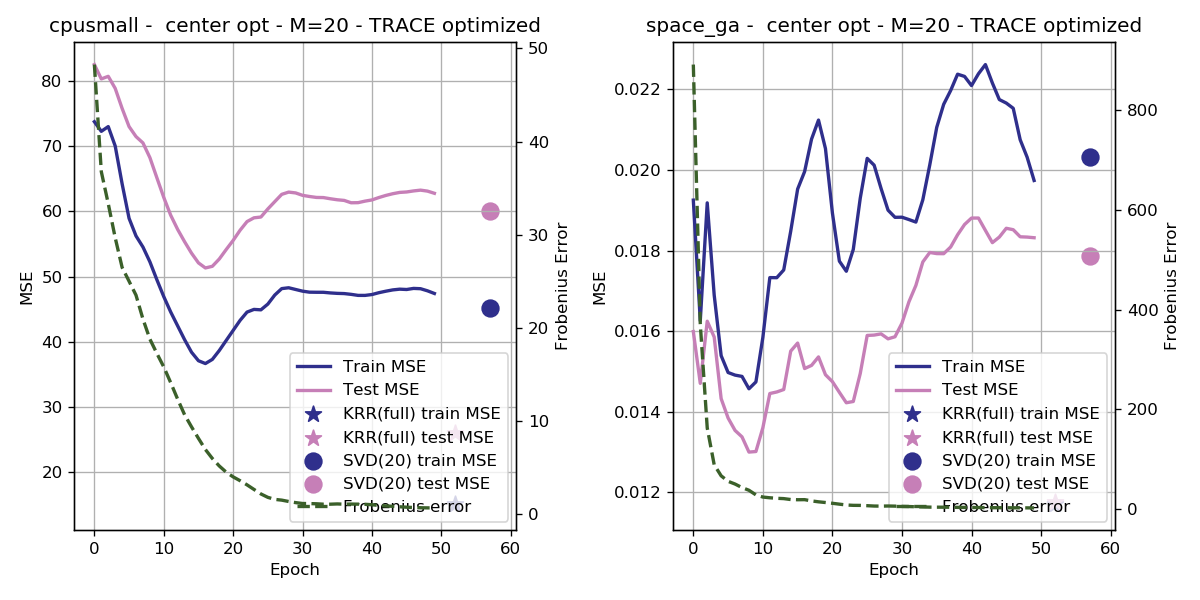

In [55]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for i, (dset_name, data) in enumerate(only_trace_20.items()):
    title = get_title("", 20, True, dset_name)
    opt_plot(data, 20, title, figax=(fig, ax[i]))

In [1664]:
res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=penalty_init, sigma_init=sigma_init, 
                           centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                           epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff 2.92255e+03 - loss -3.18570e+06 - trace -9.81943e+02
Epoch 0 ( 0.51s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 205.8043 - Ts  mse = 400.1863
VALUE        d_eff 2.92240e+03 - loss -3.04782e+06 - trace -9.72740e+02
Epoch 1 ( 1.05s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 96.5280 - Ts  mse = 232.5613
VALUE        d_eff 2.92237e+03 - loss -2.99584e+06 - trace -9.69586e+02
Epoch 2 ( 1.56s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 68.1784 - Ts  mse = 165.8357
VALUE        d_eff 2.92227e+03 - loss -2.96395e+06 - trace -9.65729e+02
Epoch 3 ( 2.05s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 44.7402 - Ts  mse = 124.2001
VALUE        d_eff 2.92218e+03 - loss -2.94091e+06 - trace -9.61989e+02
Epoch 4 ( 2.56s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 38.4543 - Ts  mse = 103.0113
VALUE        d_eff 2.92210e+03 - loss -2.92169e+06 - trace -9.58385e+02
Epoch 5 ( 3.09s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 29.1500 - Ts  mse = 85.8233
VALUE        d_e

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


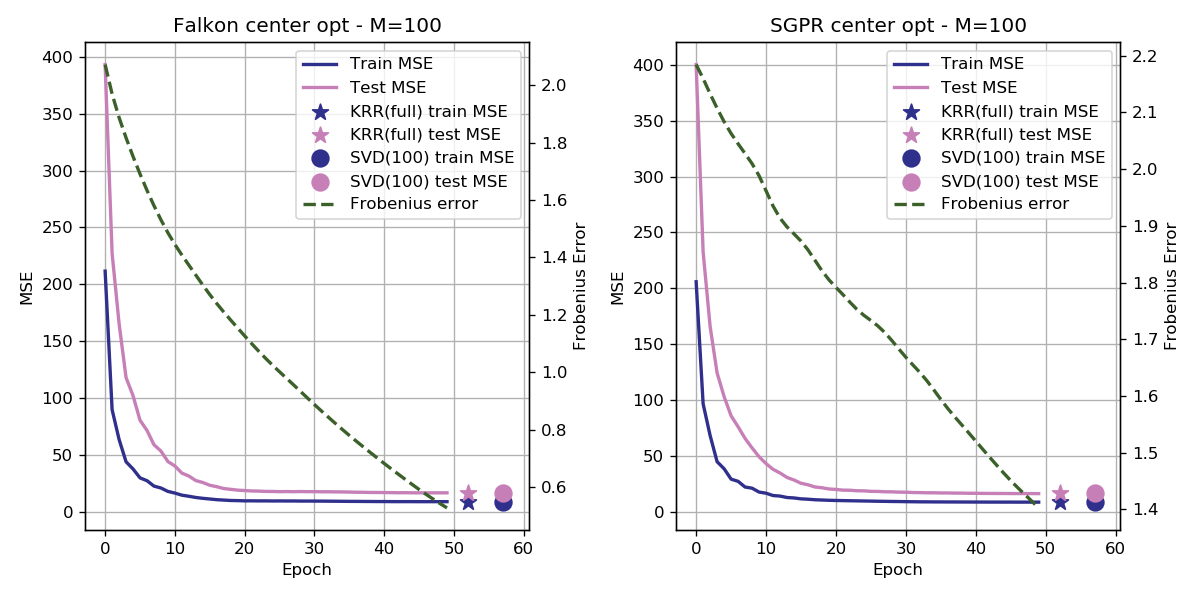

In [1665]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


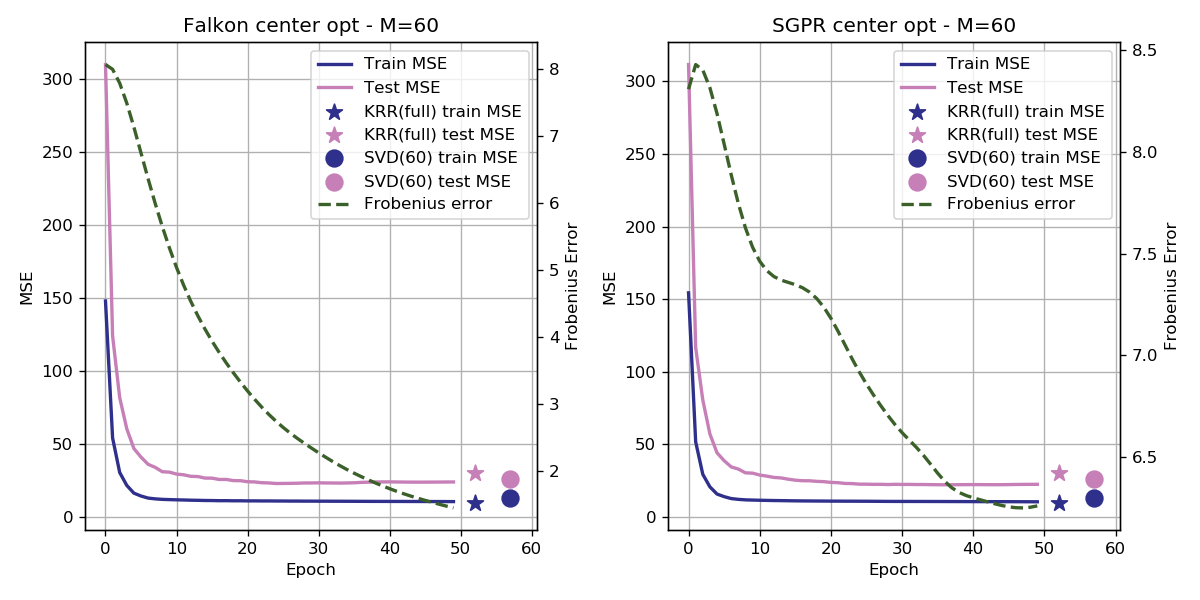

In [1659]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


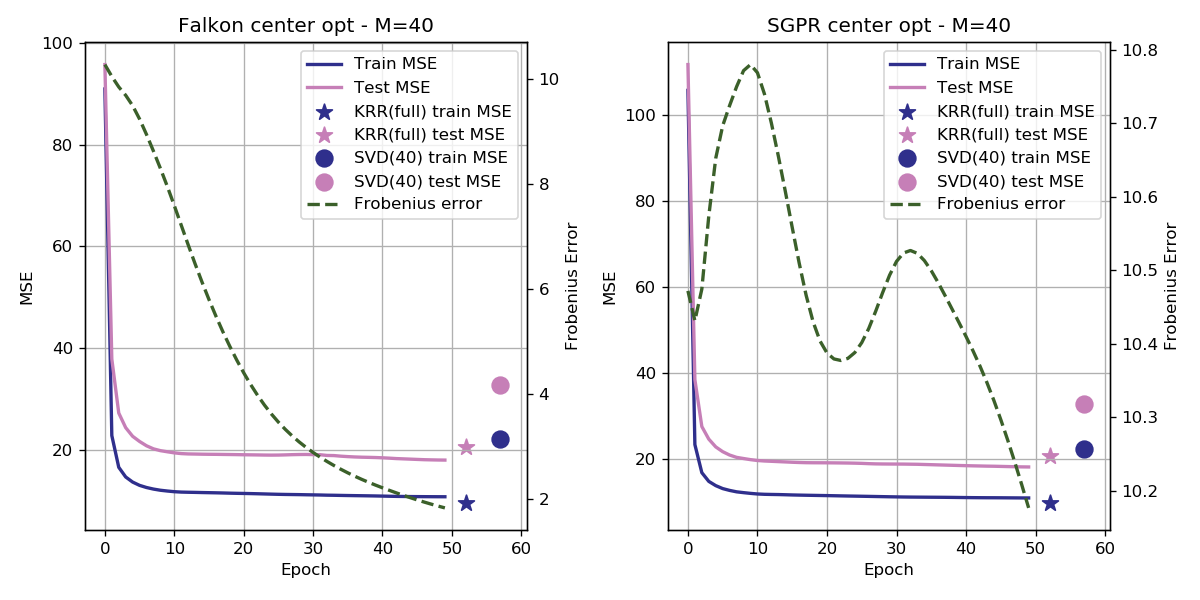

In [1653]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


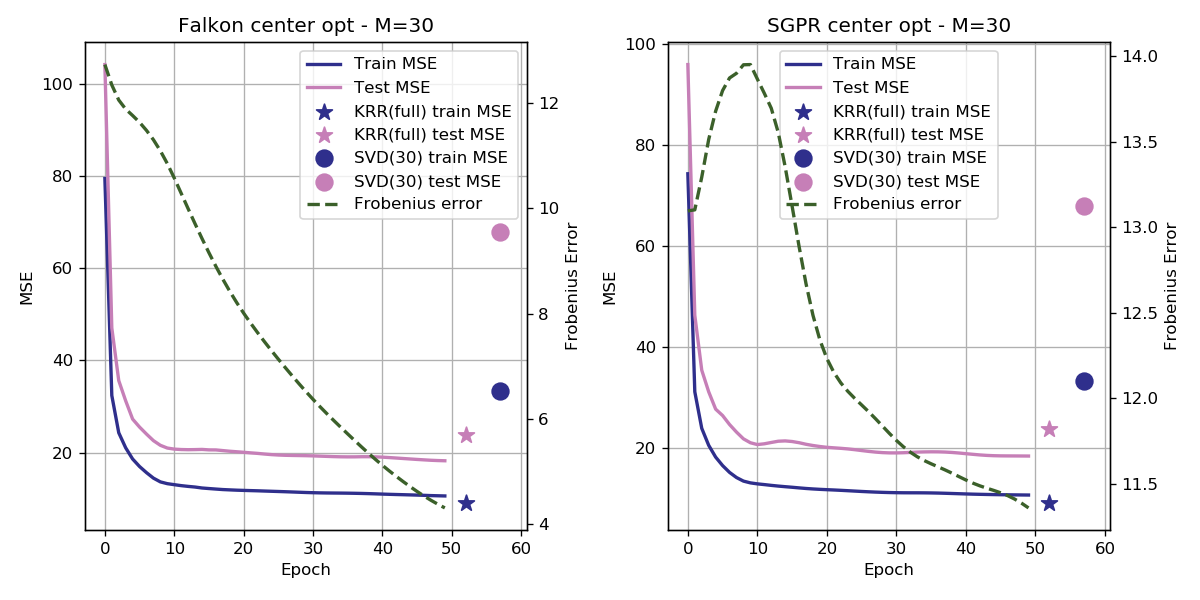

In [1647]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

<IPython.core.display.Javascript object>


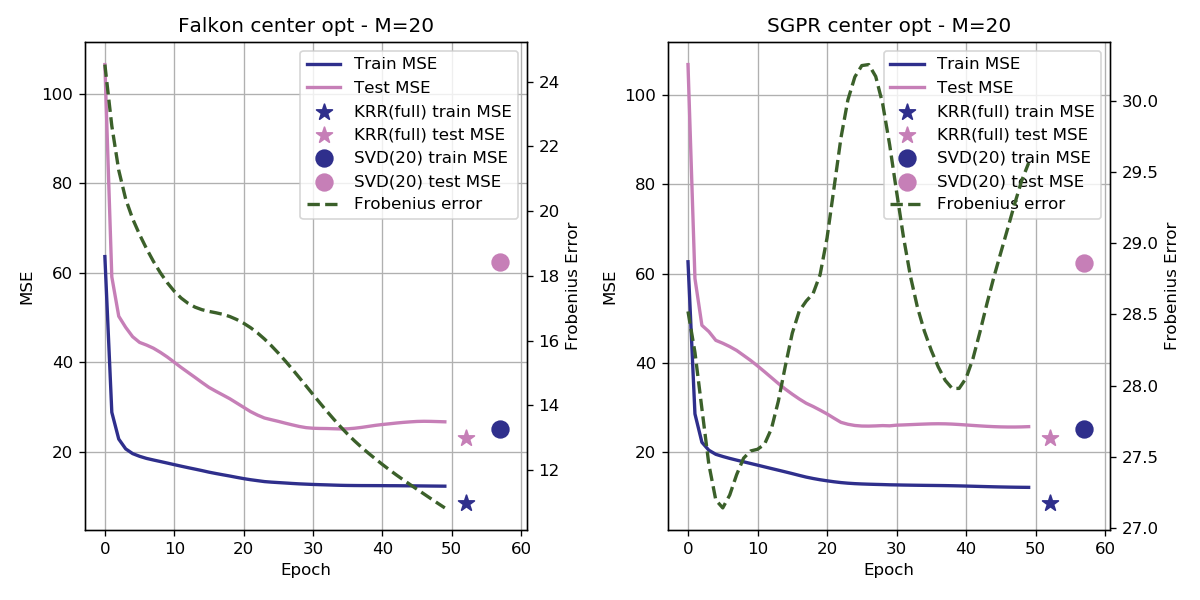

In [1641]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

In [1626]:
res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init, 
                          centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                          epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -3.71294e+03
Epoch 0 ( 0.41s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 68.6537 - Ts  mse = 98.1796
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -3.34330e+03
Epoch 1 ( 0.83s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 52.6933 - Ts  mse = 64.6181
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -3.13530e+03
Epoch 2 ( 1.27s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 48.7854 - Ts  mse = 60.2560
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.99325e+03
Epoch 3 ( 1.69s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 48.7269 - Ts  mse = 59.4026
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.88373e+03
Epoch 4 ( 2.13s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 49.0363 - Ts  mse = 58.8953
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.79211e+03
Epoch 5 ( 2.78s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 49.3941 - Ts  mse = 58.6766
VALUE        d_eff 0.00000e+

In [1548]:
res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=penalty_init, sigma_init=sigma_init, 
                           centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                           epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -6.63416e+04
Epoch 0 ( 0.47s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 77.9894 - Ts  mse = 92.9177
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -5.59427e+04
Epoch 1 ( 0.91s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 61.5331 - Ts  mse = 64.2384
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -5.11572e+04
Epoch 2 ( 1.36s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 58.9901 - Ts  mse = 65.7682
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.79725e+04
Epoch 3 ( 1.81s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 59.9734 - Ts  mse = 65.6023
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.54046e+04
Epoch 4 ( 2.26s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 61.1089 - Ts  mse = 67.4254
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.31272e+04
Epoch 5 ( 2.71s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 62.0902 - Ts  mse = 68.2037
VALUE        d_eff 0.00000e+00 - l

<IPython.core.display.Javascript object>


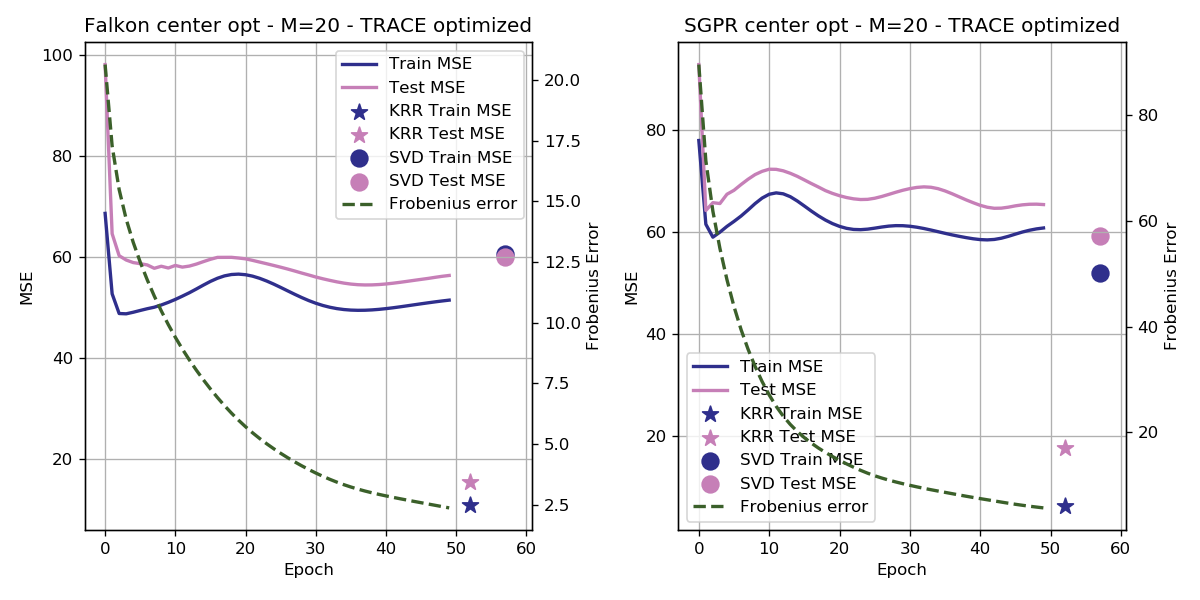

In [1627]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, title, figax=(fig, ax[1]));

<IPython.core.display.Javascript object>


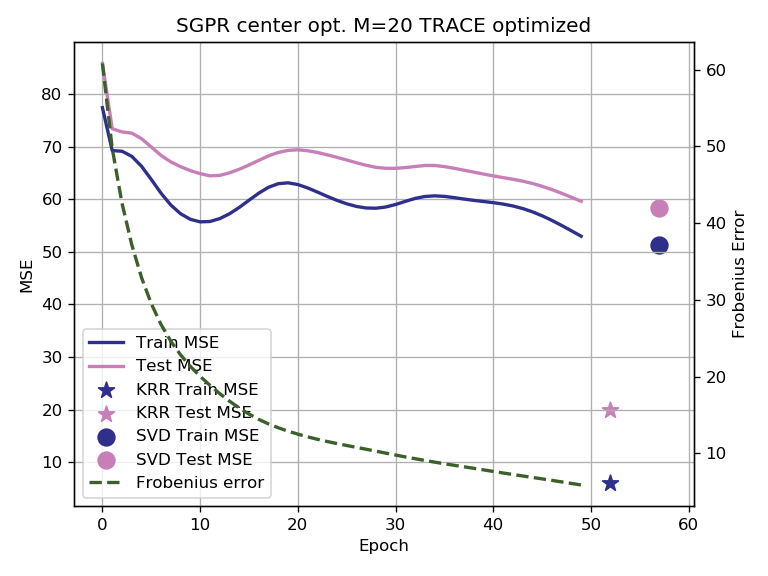

In [1532]:
title = "%s center opt. M=%d" % (opt_model, M)
if train_only_trace:
    title += " TRACE optimized"
fig, ax = opt_plot(train_errors, test_errors, fro_errors, tr_err_krr, ts_err_krr, tr_err_svd, ts_err_svd, num_epochs, title)
fig.tight_layout()

<IPython.core.display.Javascript object>


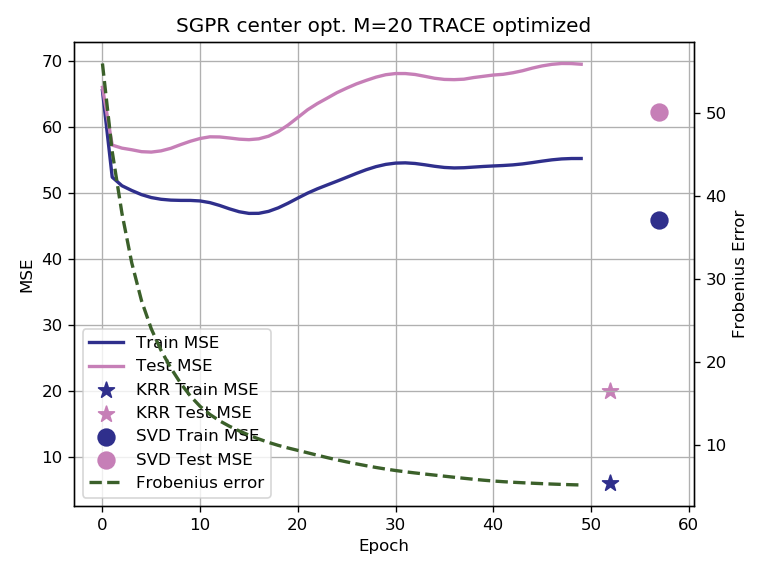

In [1510]:
fig, ax = plt.subplots()
ax.plot(range(num_epochs), train_errors, label="Train MSE", color="#2f2f8c", lw=2)
ax.plot(range(num_epochs), test_errors, label="Test MSE", color="#c67fb7", lw=2)

ax1 = ax.twinx()
ax1.plot(range(num_epochs), fro_errors, color="#3b602a", linestyle="--", label="Frobenius error", lw=2)


ax.scatter(num_epochs + 2, tr_err_krr, label="KRR Train MSE", s=100, marker="*", color="#2f2f8c")
ax.scatter(num_epochs + 2, ts_err_krr, label="KRR Test MSE", s=100, marker="*", color="#c67fb7")

ax.scatter(num_epochs + 7, tr_err_svd, label="SVD Train MSE", s=100, marker="o", color="#2f2f8c")
ax.scatter(num_epochs + 7, ts_err_svd, label="SVD Test MSE", s=100, marker="o", color="#c67fb7")


lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="best")

ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax1.set_ylabel("Frobenius Error")
title = "SGPR center opt. M=%d" % (M)
if train_only_trace:
    title += " TRACE optimized"
ax.set_title(title)
fig.tight_layout()

<IPython.core.display.Javascript object>


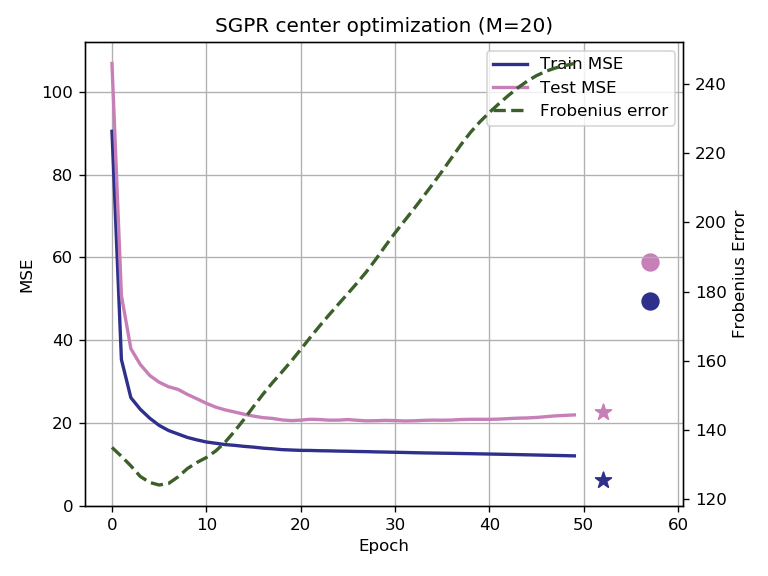

In [1495]:
fig, ax = plt.subplots()
ax.plot(range(num_epochs), train_errors, label="Train MSE", color="#2f2f8c", lw=2)
ax.plot(range(num_epochs), test_errors, label="Test MSE", color="#c67fb7", lw=2)

ax1 = ax.twinx()
ax1.plot(range(num_epochs), fro_errors, color="#3b602a", linestyle="--", label="Frobenius error", lw=2)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="best")

ax.scatter(num_epochs + 2, tr_err_krr, label="KRR Train MSE", s=100, marker="*", color="#2f2f8c")
ax.scatter(num_epochs + 2, ts_err_krr, label="KRR Test MSE", s=100, marker="*", color="#c67fb7")

ax.scatter(num_epochs + 7, tr_err_svd, label="SVD Train MSE", s=100, marker="o", color="#2f2f8c")
ax.scatter(num_epochs + 7, ts_err_svd, label="SVD Test MSE", s=100, marker="o", color="#c67fb7")

ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax1.set_ylabel("Frobenius Error")
ax.set_title("SGPR center optimization (M=%d)" % (M))
fig.tight_layout()

<IPython.core.display.Javascript object>


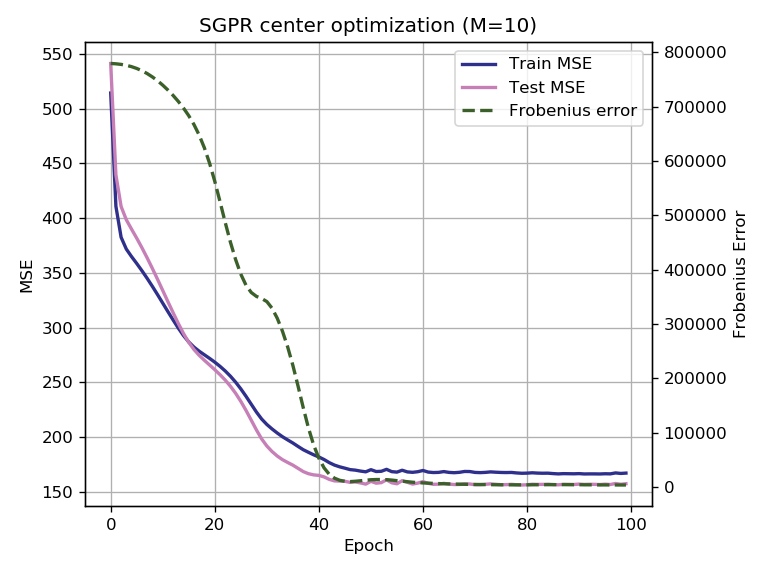

In [899]:
fig, ax = plt.subplots()
ax.plot(range(num_epochs), train_errors, label="Train MSE", color="#2f2f8c", lw=2)
ax.plot(range(num_epochs), test_errors, label="Test MSE", color="#c67fb7", lw=2)

ax1 = ax.twinx()
ax1.plot(range(num_epochs), fro_errors, color="#3b602a", linestyle="--", label="Frobenius error", lw=2)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="best")

ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax1.set_ylabel("Frobenius Error")
ax.set_title("SGPR center optimization (M=%d)" % (M))
fig.tight_layout()